In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 머신러닝 패키지
import xgboost as xgb
from sklearn.model_selection import KFold
import optuna
import time
from tqdm import tqdm

# 그래프 한글 표시
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 8)<br><br>
요일 별, 월 별 가중치 파생변수 삭제 후 학습
</div>

In [3]:

# =================================================================================================================================
# ==================================================== 시도 8 월별,요일별 가중치 삭제 후 제출 ==================================================
# =================================================================================================================================


train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)
train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)

product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)


'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
train['mapped_month'] = train['month'].map(month_mapping)   
'''

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date', 'index', 'day_of_week'] , axis = 1)

# 데이터 확인
train.head()

,country,store,product,year,month,weekday,day,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,3,0,4,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,3,0,3,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,3,0,1,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,3,0,2,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,3,1,0,2010,1,4,1,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [4]:
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [5]:
# 테스트 데이터 전처리

# 테스트 데이터 전처리

# =================================================================================================================================
# ==================================================== 테스트 데이터 전처리 (시도 4로 ) ==================================================
# =================================================================================================================================


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['week_of_year'] = test['date'].dt.isocalendar().week
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 365)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 365)
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['year_sin'] = np.sin(2 * np.pi * test['year'] / 7)
test['year_cos'] = np.cos(2 * np.pi * test['year'] / 7)
test['group'] = (test['year'] - 2010) * 48 + test['month'] * 4 + test['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
test['country'] = test['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
test['store'] = test['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
test['product'] = test['product'].map(product_mapping)

'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
test['mapped_weekday'] = test['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
test['mapped_month'] = test['month'].map(month_mapping)   
'''

# 연도별 매핑 (2017년 부터인줄 몰랐어)............
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
test['mapped_year'] = test['year'].map(year_mapping)
'''


# 필요없는 변수 삭제
test = test.drop(['id', 'date', 'day_of_week'] , axis = 1)

# 데이터 확인
test.head()


,country,store,product,year,month,weekday,day,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,3,0,0,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340
1,3,0,4,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340
2,3,0,3,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340
3,3,0,1,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340
4,3,0,2,2017,1,6,1,52,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,340


In [7]:
print(train.shape)
print(test.shape)

(221259, 15)
(98550, 15)


In [8]:
from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 가중치 변수 삭제하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 200
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')

[I 2025-01-27 11:36:04,273] A new study created in memory with name: no-name-84522d6a-bf14-412c-a7cb-15f0b2305736
XGBoost 하이퍼파라미터 튜닝 중...:   0%|                                                       | 0/200 [00:00<?, ?it/s]C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-01-27 11:36:07,558] Trial 0 finished with value: 0.0637427102835528 and parameters: {'n_estimators': 294, '

최고의 MAPE값 0.042281751825234457 

최고의 하이퍼 파라미터 {'n_estimators': 1433, 'learning_rate': 0.06577429086290515, 'max_depth': 11, 'subsample': 0.7623970628578274, 'colsample_bytree': 0.9807525044569172, 'min_child_weight': 6, 'gamma': 0.0007222076305085732, 'reg_alpha': 1.1191881067061473, 'reg_lambda': 8.375651254942353} 



Feature Importances:
         Feature  Importance
0        country    0.669586
2        product    0.180445
1          store    0.134637
13      year_cos    0.005076
3           year    0.001982
10     month_sin    0.001923
5        weekday    0.001649
7   week_of_year    0.001284
11     month_cos    0.001045
4          month    0.000954
14         group    0.000876
12      year_sin    0.000434
6            day    0.000078
8        day_sin    0.000032
9        day_cos    0.000000


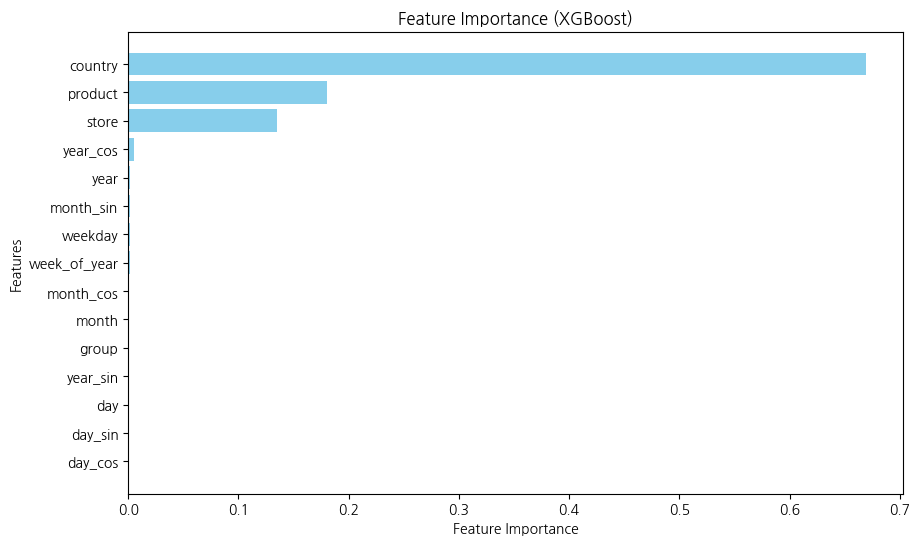

In [9]:
# 최적의 하이퍼파라미터 가져오기
best_params = {  
    'n_estimators': 1433,
    'learning_rate': 0.06577429086290515,
    'max_depth': 11,
    'subsample': 0.7623970628578274,
    'colsample_bytree': 0.9807525044569172,
    'min_child_weight': 6,
    'gamma': 0.0007222076305085732,
    'reg_alpha': 1.1191881067061473,
    'reg_lambda': 8.375651254942353,
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
} 

# 로그 변환된 타겟 값 사용
log_y_df = np.log(y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

# 예측 및 지수 함수로 변환
y_pred_log = final_xgb_model.predict(test)
y_pred = np.exp(y_pred_log)  # 로그 변환된 값을 지수 함수로 복원

# 변수 중요도 추출
feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

In [10]:
sub_8 = sub.copy()
sub_8['num_sold'] = y_pred

sub_8.to_csv('sub_8.csv', index = False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 9)<br><br>
가중치 변수 삭제 후 반년 주기 다시 추가
</div>

In [18]:

# =================================================================================================================================
# ==================================================== 가중치 변수 없이 6개월 주기 추가  ==================================================
# =================================================================================================================================


train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['half_year_sin'] = np.sin(2 * np.pi * train['day'] / 182.5)
train['half_year_cos'] = np.cos(2 * np.pi * train['day'] / 182.5)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)
train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)

product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)


'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
train['mapped_month'] = train['month'].map(month_mapping)   
'''

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date', 'index', 'day_of_week'] , axis = 1)



# ------------------------------------------------- 테스트 데이터 전처리 ----------------------------------------------------------------


# 테스트 데이터 전처리

# 테스트 데이터 전처리

# =================================================================================================================================
# ==================================================== 테스트 데이터 전처리 (시도 4로 ) ==================================================
# =================================================================================================================================

test = pd.read_csv('test.csv')

# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['week_of_year'] = test['date'].dt.isocalendar().week
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 365)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 365)
test['half_year_sin'] = np.sin(2 * np.pi * test['day'] / 182.5)
test['half_year_cos'] = np.cos(2 * np.pi * test['day'] / 182.5)
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['year_sin'] = np.sin(2 * np.pi * test['year'] / 7)
test['year_cos'] = np.cos(2 * np.pi * test['year'] / 7)
test['group'] = (test['year'] - 2010) * 48 + test['month'] * 4 + test['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
test['country'] = test['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
test['store'] = test['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
test['product'] = test['product'].map(product_mapping)

'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
test['mapped_weekday'] = test['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
test['mapped_month'] = test['month'].map(month_mapping)   
'''

# 연도별 매핑 (2017년 부터인줄 몰랐어)............
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
test['mapped_year'] = test['year'].map(year_mapping)
'''


# 필요없는 변수 삭제
test = test.drop(['id', 'date', 'day_of_week'] , axis = 1)

# 데이터 확인


# --------------------------------------------------- 시도 9 학습 ---------------------------------------------------------



from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 가중치 변수 삭제하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 200
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')



# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------


# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
     "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"})

# 로그 변환된 타겟 값 사용
log_y_df = np.log(y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

# 예측 및 지수 함수로 변환
y_pred_log = final_xgb_model.predict(test)
y_pred = np.exp(y_pred_log)  # 로그 변환된 값을 지수 함수로 복원

# 변수 중요도 추출
feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()



# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

sub_9 = sub.copy()
sub_9['num_sold'] = y_pred

sub_9.to_csv('sub_9.csv', index = False)

[I 2025-01-27 12:34:16,143] A new study created in memory with name: no-name-35273719-2888-47c3-8bf8-c65fd147154b
XGBoost 하이퍼파라미터 튜닝 중...: 100%|█████████████████████████████████████████████| 200/200 [47:33<00:00, 14.27s/it]

최고의 MAPE값 0.043561411800510784 

최고의 하이퍼 파라미터 {'n_estimators': 1459, 'learning_rate': 0.07100989831610854, 'max_depth': 15, 'subsample': 0.7579231780007842, 'colsample_bytree': 0.9620222049633008, 'min_child_weight': 2, 'gamma': 0.0020781338196793654, 'reg_alpha': 4.493428425036715, 'reg_lambda': 8.83274058517804} 



AttributeError: 'float' object has no attribute 'update'

Feature Importances:
          Feature  Importance
0         country    0.663392
1           store    0.182490
2         product    0.144021
15       year_cos    0.002969
5         weekday    0.001970
3            year    0.001222
12      month_sin    0.001180
4           month    0.000667
13      month_cos    0.000610
7    week_of_year    0.000595
16          group    0.000503
14       year_sin    0.000288
6             day    0.000055
8         day_sin    0.000038
11  half_year_cos    0.000000
10  half_year_sin    0.000000
9         day_cos    0.000000


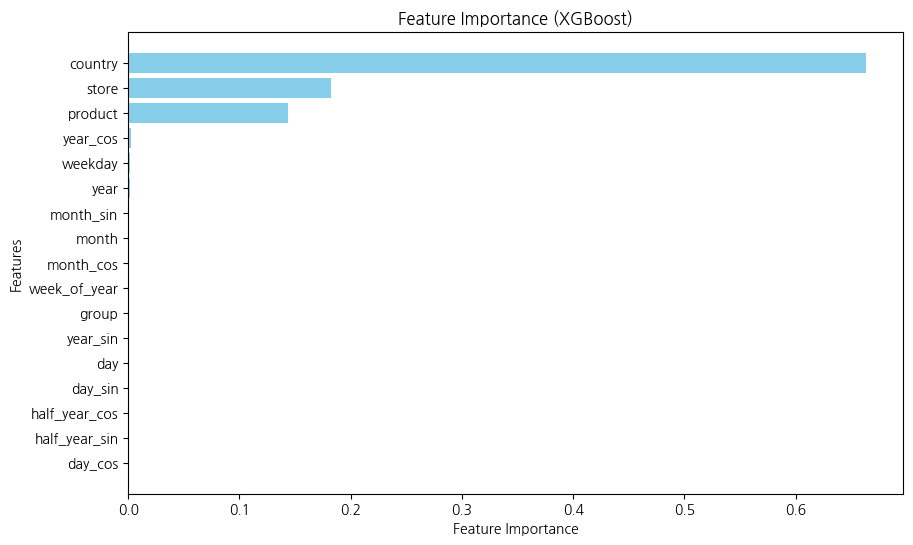

In [26]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------


# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
     "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"})

# 로그 변환된 타겟 값 사용
log_y_df = np.log(y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

# 예측 및 지수 함수로 변환
y_pred_log = final_xgb_model.predict(test)
y_pred = np.exp(y_pred_log)  # 로그 변환된 값을 지수 함수로 복원

# 변수 중요도 추출
feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()



# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

sub_9 = sub.copy()
sub_9['num_sold'] = y_pred

sub_9.to_csv('sub_9.csv', index = False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(시도 10)<br><br>
GDP 변수 추가 (시도 중단함)
</div>

In [ ]:

# =================================================================================================================================
# ==================================================== 가중치 변수 없이 6개월 주기 추가  ==================================================
# =================================================================================================================================


train = pd.read_csv('train.csv')
train = train.dropna()
train = train.reset_index()


# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['day_sin'] = np.sin(2 * np.pi * train['day'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 365)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['year_sin'] = np.sin(2 * np.pi * train['year'] / 7)
train['year_cos'] = np.cos(2 * np.pi * train['year'] / 7)
train['group'] = (train['year'] - 2010) * 48 + train['month'] * 4 + train['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
train['country'] = train['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
train['store'] = train['store'].map(store_mapping)

product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
train['product'] = train['product'].map(product_mapping)


'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
train['mapped_weekday'] = train['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
train['mapped_month'] = train['month'].map(month_mapping)   
'''

# 연도별 배핑
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
train['mapped_year'] = train['year'].map(year_mapping)
'''

# 반응변수 추출
y_df = train['num_sold']
log_y_df = np.log1p(y_df)

# 필요없는 변수 삭제
train = train.drop(['num_sold', 'id', 'date', 'index', 'day_of_week'] , axis = 1)



# ------------------------------------------------- 테스트 데이터 전처리 ----------------------------------------------------------------


# 테스트 데이터 전처리

# 테스트 데이터 전처리

# =================================================================================================================================
# ==================================================== 테스트 데이터 전처리 (시도 4로 ) ==================================================
# =================================================================================================================================

test = pd.read_csv('test.csv')

# -------------------------------------------------------------데이터 전처리

# 날짜 파생 변수 생성
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['week_of_year'] = test['date'].dt.isocalendar().week
test['day_sin'] = np.sin(2 * np.pi * test['day'] / 365)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 365)
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['year_sin'] = np.sin(2 * np.pi * test['year'] / 7)
test['year_cos'] = np.cos(2 * np.pi * test['year'] / 7)
test['group'] = (test['year'] - 2010) * 48 + test['month'] * 4 + test['day'] // 7


# ------------------------------------------------------------------ 인코딩

country_mapping = {
    'Kenya': 0,
    'Italy': 1,
    'Finland': 2,
    'Canada': 3,
    'Singapore': 4,
    'Norway': 5}
test['country'] = test['country'].map(country_mapping)


store_mapping = {
    'Discount Stickers' : 0,
    'Stickers for Less' : 1,
    'Premium Sticker Mart' : 2}
test['store'] = test['store'].map(store_mapping)


product_mapping = {
    'Holographic Goose' : 0,
    'Kerneler' : 1,
    'Kerneler Dark Mode' : 2,
    'Kaggle Tiers' : 3,
    'Kaggle' : 4}
test['product'] = test['product'].map(product_mapping)

'''
# (월,화,수,목 = 0) (금 = 1) (토 = 2) (일 = 3)
weekday_mapping = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3}
test['mapped_weekday'] = test['weekday'].map(weekday_mapping)
'''

'''
# 월별 매핑
month_mapping = {
    2: 1, 5: 1, 4: 1, 3: 1,   # 2, 5, 4, 3월 → 1
    9: 2, 10: 2,              # 9, 10월 → 2
    6: 3, 7: 3, 8: 3,         # 6, 7, 8월 → 3
    1: 4, 11: 4,              # 1, 11월 → 4
    12: 5}                     # 12월 → 5
test['mapped_month'] = test['month'].map(month_mapping)   
'''

# 연도별 매핑 (2017년 부터인줄 몰랐어)............
'''
year_mapping = {
    2011: 1, 2013: 1,  # 2011년, 2013년 → 1
    2012: 2, 2014: 2,  # 2012년, 2014년 → 2
    2010: 3, 2015: 3, 2016: 3} # 2010년, 2015년, 2016년 → 3
test['mapped_year'] = test['year'].map(year_mapping)
'''


# 필요없는 변수 삭제
test = test.drop(['id', 'date', 'day_of_week'] , axis = 1)

# 데이터 확인


# --------------------------------------------------- 시도 9 학습 ---------------------------------------------------------



from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------- 가중치 변수 삭제하고 학습  ---------------------------------------------------

# ----------------------------------------------------- 데이터 학습 --------------------------------------------------------------

# 목적함수 생성
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # 트리 개수
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # 학습률
    'max_depth': trial.suggest_int('max_depth', 3, 15),  # 트리 최대 깊이
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # 샘플링 비율
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # 특성 샘플링 비율
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # 리프 노드 최소 가중치
    'gamma': trial.suggest_float('gamma', 0, 10),  # 최소 손실 감소
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 정규화
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),  # L2 정규화
    "tree_method": "hist",  # 트리 방법
    "device": "cuda",       # GPU 사용
    "objective": "reg:squarederror",
    'random_state': 1
}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    xgb_scores = []

    for train_index, val_index in kf.split(train):
        x_train, x_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = log_y_df[train_index], log_y_df[val_index]

        # XGBoost 모델 생성
        xgb_model = xgb.XGBRegressor(**params)
        xgb_model.fit(x_train, y_train)

        # 예측 및 RMSLE 계산
        y_pred = np.exp(xgb_model.predict(x_val))
        mape = mean_absolute_percentage_error(np.exp(y_val), y_pred)
        xgb_scores.append(mape)

    return np.mean(xgb_scores)

# Optuna 하이퍼파라미터 최적화
n_trials = 200
xgb_study = optuna.create_study(direction='minimize')

for _ in tqdm(range(n_trials), desc='XGBoost 하이퍼파라미터 튜닝 중...'):
    xgb_study.optimize(objective, n_trials=1, catch=(Exception,))

print('최고의 MAPE값', xgb_study.best_value, '\n')
print('최고의 하이퍼 파라미터', xgb_study.best_params, '\n')



# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------


# 최적의 하이퍼파라미터 가져오기
best_params = xgb_study.best_params
best_params.update({
     "tree_method": "hist",  
    "device": "cuda",       
    "objective": "reg:squarederror"})

# 로그 변환된 타겟 값 사용
log_y_df = np.log(y_df)

# 최적의 파라미터로 최종 모델 학습
final_xgb_model = xgb.XGBRegressor(**best_params)
final_xgb_model.fit(train, log_y_df)

# 예측 및 지수 함수로 변환
y_pred_log = final_xgb_model.predict(test)
y_pred = np.exp(y_pred_log)  # 로그 변환된 값을 지수 함수로 복원

# 변수 중요도 추출
feature_importances = final_xgb_model.feature_importances_
features = train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()



# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

sub_9 = sub.copy()
sub_9['num_sold'] = y_pred

sub_9.to_csv('sub_9.csv', index = False)